In [ ]:
# default_exp datasets.bases.basket

# Next-Basket Dataset
> Implementation of dataset modules for next-basket recommendation task.

In [ ]:
#hide
from nbdev.showdoc import *
from fastcore.nb_imports import *
from fastcore.test import *

In [ ]:
#export
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.feature_extraction.text import CountVectorizer, _VectorizerMixin
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import matplotlib.ticker as ticker
import csv
import json
import os
import random
import time

from recohut.visualization.basic_plots import BasicVisual

## BasketVectorizer

In [ ]:
#export
class BasketVectorizer:
    """
    This class is responsible for converting a basket into one hot vectors
    """
    def __init__(self, vocabulary):
        self.vocabulary = vocabulary
        self._cv = CountVectorizer(vocabulary=self.vocabulary, token_pattern=r"\b\d+\b", preprocessor=self._preprocess)

    @staticmethod
    def _preprocess(doc):
        """
        The default vectorizer only accepts list of strings, we also want it to accept list of list or list of arrays
        """
        if isinstance(doc, list) or isinstance(doc, np.ndarray):
            return ",".join(doc)
        return doc

    def transform(self, X, toarray=False):
        if toarray:
            return self._cv.transform(X).toarray()
        else:
            return self._cv.transform(X)

    def get_cv(self):
        return self._cv

In [ ]:
cab = {str(i) for i in range(1, 11)}
bc = BasketVectorizer(vocabulary=cab)

test_eq(bc.get_cv().get_feature_names_out(), 
        np.array(['1','10','2','3','4','5','6','7','8','9']))

res = bc.transform([["1", "2"], "7,8,9,10"], toarray=True)

test_eq(res, np.array([[1, 0, 1, 0, 0, 0, 0, 0, 0, 0],
                       [0, 1, 0, 0, 0, 0, 0, 1, 1, 1]]))

In [ ]:
#exporti
class BasketRepeatDistancePlot(BasicVisual):
    def __init__(self, repeat_distance, xlim=[0,10], **kwargs):
        self.repeat_distance = repeat_distance
        self.xlim = xlim
        super().__init__(**kwargs)

    def plot(self):
        self.ax.yaxis.set_major_formatter(ticker.PercentFormatter(len(self.repeat_distance)))
        plt.hist(self.repeat_distance, bins=np.arange(min(self.repeat_distance), 
                                                      max(self.repeat_distance)+1)-0.5)
        self.ax.set_xlim(self.xlim)

In [ ]:
#exporti
class BasketSizePlot(BasicVisual):
    def __init__(self, basket_size_series, bins=40, xlim=[0,60], **kwargs):
        self.basket_size_series = basket_size_series
        self.bins = bins
        self.xlim = xlim
        super().__init__(**kwargs)

    def plot(self):        
        plt.hist(self.basket_size_series, bins=self.bins)
        self.ax.set_xlim(self.xlim)

In [ ]:
#exporti
class BasketUserPlot(BasicVisual):
    def __init__(self, baskets_per_user_series, bins=40, xlim=[0,60], **kwargs):
        self.baskets_per_user_series = baskets_per_user_series
        self.bins = bins
        self.xlim = xlim
        super().__init__(**kwargs)

    def plot(self):        
        plt.hist(self.baskets_per_user_series, bins=self.bins)
        self.ax.set_xlim(self.xlim)

In [ ]:
#export
class BasketDataset:
    def __init__(self,
                 df: pd.DataFrame,
                 user_col: str = 'user_id',
                 item_col: str = 'item_id',
                 basket_col: str = 'order_id',
                 auto_process: bool = True,
                 ):
        self.df = df[[user_col, item_col, basket_col]].copy()
        self.user_col = user_col
        self.item_col = item_col
        self.basket_col = basket_col

        self.customer_baskets = dict()
        # this is to store the sparse matrix
        self.customer_baskets_vectorized = dict()
        self.item_ids = None
        self.customer_ids = None
        # process
        if auto_process:
            self.process()

    def process(self):
        self.df = self.df.astype({self.user_col: str, self.item_col: str, self.basket_col: int})
        for customer_id, customer_baskets_df in self.df.groupby(self.user_col):
            self.customer_baskets[customer_id] = []
            for order_id, basket in customer_baskets_df.groupby(self.basket_col):
                items_in_basket = basket[self.item_col].values
                self.customer_baskets[customer_id].append((order_id, items_in_basket))
        # update other attributes based on customer_baskets
        self._update_stats()
        # convert baskets to one hot encoded
        self.vectorize()
        # calculate repeat distance
        self._calculate_repeat_distance()
        # calculate other stats
        self.basket_size_series = self.df.groupby([self.user_col, self.basket_col]).count()[self.item_col]
        self.baskets_per_user_series = \
        self.df[[self.user_col, self.basket_col]].drop_duplicates().groupby([self.user_col]).count()[self.basket_col]

    def info(self):
        num_customer = self.df[self.user_col].unique().size
        print("num of customers:", num_customer)

        num_customer = self.df[self.item_col].unique().size
        print("num of items:", num_customer)

        basket_size_avg = self.basket_size_series.mean()
        print("avg basket size:", basket_size_avg)

        print("avg basket per user:", self.baskets_per_user_series.mean())
        print("number of baskets:", self.df[[self.user_col, self.basket_col]].drop_duplicates().shape[0])

        print("percentage of repeat baskets:", self.count_of_baskets_with_repeat/self.count_of_all_baskets)
        print("average repeat distance:", np.mean(self.repeat_distance)) 

    def _update_stats(self):
        self.number_of_baskets_per_customer = dict()
        customer_ids = set()
        item_ids = set()
        for _cid, _baskets in self.customer_baskets.items():
            customer_ids.add(_cid)
            self.number_of_baskets_per_customer[_cid] = len(_baskets)
            for _order_id, _b in _baskets:
                item_ids.update(_b)
        # we first sort the item ids, then convert it to string to be used as vocabulary
        # note that this is done in two steps to avoid miss sorting, [1,2,3..11,] into [1,11,2,3]
        self.item_ids = sorted(item_ids, key=lambda x: int(x))  # sort a dict will return a list
        self.customer_ids = sorted(customer_ids, key=lambda x: int(x))  # sort a dict will return a list

    def vectorize(self):
        vocabulary = self.item_ids
        bc = BasketVectorizer(vocabulary=vocabulary)
        for cid in self.customer_ids:
            self.customer_baskets_vectorized[cid] = []
            for order_id, raw_basket in self.customer_baskets[cid]:
                vec_tuple = (order_id, bc.transform([raw_basket], toarray=False)[0])
                self.customer_baskets_vectorized[cid].append(vec_tuple)

    def _calculate_repeat_distance(self):
        count_of_baskets_with_repeat = 0
        count_of_all_baskets = 0
        repeat_distance = []
        for customerId, baskets in self.customer_baskets.items():
            customerVocab = set()
            for idx, (orderId, basket) in enumerate(baskets):
                hasRepeat = False
                distance = []
                for itemId in basket:
                    if itemId in customerVocab:
                        hasRepeat = True
                        # find the closest repeat place
                        for backIdx in range(idx-1, -1, -1):
                            thisCustomerBasket = baskets[backIdx]
                            if itemId in thisCustomerBasket[1]:
                                distance.append(idx - backIdx)
                # we choose the minimal distance to represent
                if distance:
                    repeat_distance.append(min(distance))              
                if hasRepeat:
                    # this basket has repeated item
                    count_of_baskets_with_repeat += 1
                count_of_all_baskets += 1
                customerVocab.update(basket)
        self.repeat_distance = repeat_distance
        self.count_of_baskets_with_repeat = count_of_baskets_with_repeat
        self.count_of_all_baskets = count_of_all_baskets

    def plot_basket_distance(self, xlim=[0,10]):
        kwargs = {'label_x':'repeat distance', 'label_y':'baskets percentage', 
                  'figsize':(7,4), 'title':'Repeat Distance Plot'}
        _ = BasketRepeatDistancePlot(self.repeat_distance, xlim=xlim, **kwargs)

    def plot_basket_size(self, bins=40, xlim=[0,60]):
        kwargs = {'label_x':'basket_size', 'label_y':'#baskets', 
                  'figsize':(7,4), 'title':'Basket Size Plot'}
        _ = BasketSizePlot(self.basket_size_series, bins=bins, xlim=xlim, **kwargs)

    def plot_basket_per_user(self, bins=40, xlim=[0,60]):
        kwargs = {'label_x':'#baskets', 'label_y':'#users', 
                  'figsize':(7,4), 'title':'Baskets per user Plot'}
        _ = BasketUserPlot(self.baskets_per_user_series, bins=bins, xlim=xlim, **kwargs)

    def generate(self, number_of_baskets_per_customer=10, max_customer_id=10000, max_item_id=1000, basket_size=20):
        print("generating fake dataset")
        self.customer_ids = {cid for cid in range(1, max_customer_id + 1)}
        self.item_ids = [iid for iid in range(1, max_item_id + 1)]
        self.number_of_baskets_per_customer = {cid: number_of_baskets_per_customer for cid in self.customer_ids}
        # we manually partition customers into 3 clusters, 1/3 likes the first 1/3 of items, ...
        for cid in self.customer_ids:
            self.customer_baskets[cid] = []
            if cid <= max_customer_id // 3:
                items_they_like = range(1, max_item_id // 3)
            elif cid <= max_customer_id * 2 // 3:
                items_they_like = range(max_item_id // 3, 2 * max_item_id // 3)
            else:
                items_they_like = range(2 * max_item_id // 3, max_item_id + 1)

            for i in range(number_of_baskets_per_customer):
                basket = np.array([random.choice(items_they_like) for i in range(basket_size)])
                self.customer_baskets[cid].append(basket)

    def to_vocab(self, file_path):
        if Self.item_ids is None:
            raise ValueError("no vocab to save, item Ids missing")
        df = pd.DataFrame({"itemId": self.item_ids})
        df.to_csv(file_path, index=False)

    def to_json_baskets(self, jsondata_path):
        for customerId, list_of_baskets in self.customer_baskets.items():
            # suppose the list_of_baskets is sorted
            for orderId, basket_array in list_of_baskets:
                d_temp = {"customerId": int(customerId), "orderId": orderId,
                          "basket": list(map(lambda x: int(x), basket_array.tolist())), "isDeletion": False}

                fp = os.path.join(jsondata_path, f"customer_{customerId}_order_{orderId}.csv")
                json.dump(d_temp, open(fp, "w"))
                print(f"Writing {fp} ...")
                time.sleep(0.1)

### Example - TaFang Dataset

In [ ]:
df = pd.read_csv('https://github.com/RecoHut-Datasets/tafeng/raw/v2/TaFang_history_NB.csv')
df.head()

,CUSTOMER_ID,ORDER_NUMBER,MATERIAL_NUMBER
0,1,1,1
1,1,1,2
2,1,1,3
3,1,2,4
4,1,2,5


In [ ]:
ds = BasketDataset(df, user_col='CUSTOMER_ID', item_col='MATERIAL_NUMBER',
                   basket_col='ORDER_NUMBER')


ds.info()

num of customers: 13949
num of items: 11997
avg basket size: 6.220074789418682
avg basket per user: 5.693813176571798
number of baskets: 79423
percentage of repeat baskets: 0.3630938141344447
average repeat distance: 2.816006657881961


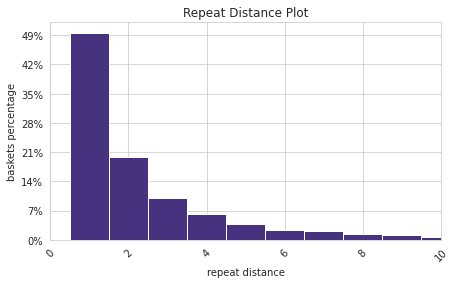

In [ ]:
ds.plot_basket_distance()

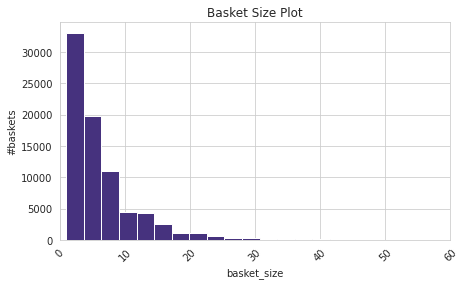

In [ ]:
ds.plot_basket_size()

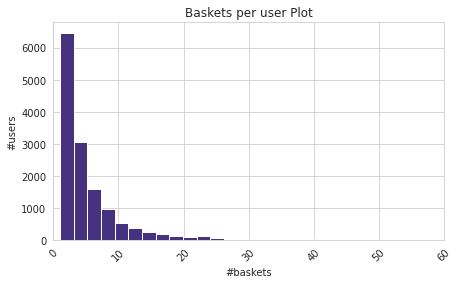

In [ ]:
ds.plot_basket_per_user()

### Example - Instacart Dataset

In [ ]:
df = pd.read_csv('https://github.com/RecoHut-Datasets/instacart/raw/v1/Instacart_history.csv')
df.head()

,CUSTOMER_ID,ORDER_NUMBER,MATERIAL_NUMBER
0,1,1,1
1,1,1,2
2,1,1,3
3,1,1,4
4,1,1,5


In [ ]:
ds = BasketDataset(df, user_col='CUSTOMER_ID', item_col='MATERIAL_NUMBER',
                   basket_col='ORDER_NUMBER')


ds.info()

num of customers: 19935
num of items: 7999
avg basket size: 8.877992613239542
avg basket per user: 7.97256082267369
number of baskets: 158933
percentage of repeat baskets: 0.7955805276437241
average repeat distance: 1.3751542184682548


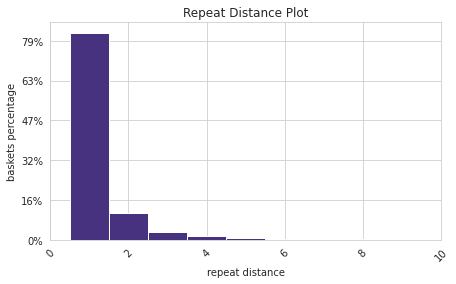

In [ ]:
ds.plot_basket_distance()

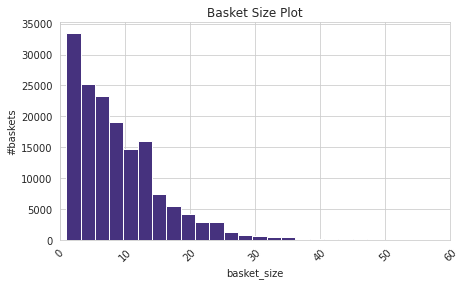

In [ ]:
ds.plot_basket_size()

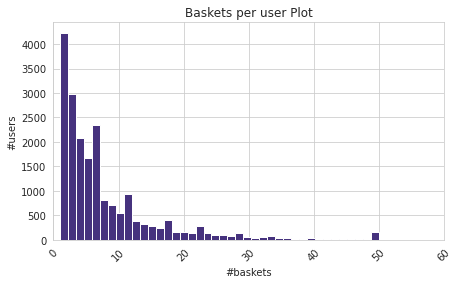

In [ ]:
ds.plot_basket_per_user()